# Create an overland search area by Lake Tahoe

ArcGIS GeoAnalytics Engine provides SQL functions that faciliate analysis on spatial data. This example uses these functions to create an overland search area near Lake Tahoe. 

![image.png](attachment:image.png "lake tahoe search area")

## Workflow overview: 

* [Set up the input data](#Set-up-the-input-data) 
    1. Create a DataFrame.
    2. View the spatial reference.
    3. Visualize the geometries with the plotting library.

* [Use SQL functions](#Use-SQL-functions-to-calculate-the-overland-search-area) to calculate the search area.
    1. Get the length of geometries with [`ST_length`](#length).
    2. Calculate the bounding polygon of the search area using different methods.
        1. Get the minimum and maximum x- and y-values with [`ST_MinX` ,`ST_MinY`, `ST_MaxX` and `ST_MaxY`](#minmaxXY).
        2. Get the union and envelope of the input geometries with [`ST_AggrUnion` and `ST_Envelope`](#envelope).
        3. Get the union and minimum bounding box of the input geometries with [`ST_AggrUnion` and `ST_MinBoundingBox`](#boundingbox).
        4. Create a polygon search area based on the track lines using `ST_AggrUnion` with [`ST_ConvexHull`](#convexhull).
    5. Read in a geometry of Lake Tahoe from a [`feature service`](#featureService).
    6. Create the lake polygon from the shoreline polygon.
        1. Create the minimum bounding box.
        2. Union the lake shorelines to a single polygon.
        3. Find the union of the minimum bounding polygon and the shorelines.
        4. Plot and investigate which union polygons represent the lake.
        5. Create a DataFrame from the shoreline polygon and the unioned lake polygons.
    7. Remove the lake geometry from the search polygon to produce the search area with [`ST_Difference`](#difference).
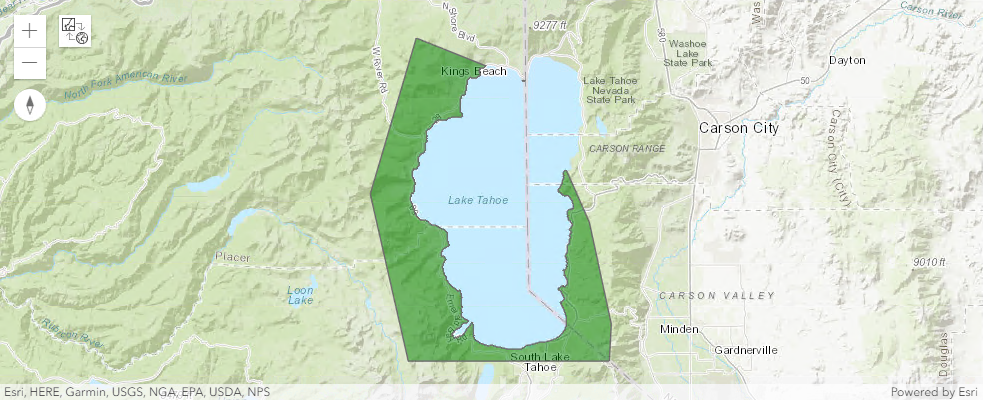

In [1]:
# Import the modules and functions and authorize geoanalytics
import geoanalytics
from geoanalytics.sql import functions as ST
from pyspark.sql import functions as F

geoanalytics.auth(username="username", password="password")

### Set up the input data

Create some sample data using the [well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) geometry representation. These linestrings represent track data around Lake Tahoe. This notebook will modify this data and join it with a dataset representing the Lake Tahoe shorelines to create a search area near Lake Tahoe.

In [2]:
# Lines around Lake Tahoe
simpleWktGeometries = [[0, "LINESTRING ( 745402.258 4350363.2255, 740456.0998 4331818.7436, 745645.1947 4312180.3375 )"],
                       [1, "LINESTRING ( 745645.1947 4312180.3375, 769561.701 4312921.3398 )"],
                       [2, "LINESTRING ( 769663.8653 4317331.4107, 766636.3143 4321717.1894, 766554.807 4329390.0323 )"],
                       [3, "LINESTRING ( 764298.3925 4317235.5774, 759713.9219 4321008.9328, 758496.6481 4345755.1707 )"]]

In [3]:
# Create a Spark DataFrame with named columns
df = spark.createDataFrame(simpleWktGeometries).toDF("line_id", "wkt")
df.printSchema()
df.show(2) 

root
 |-- line_id: long (nullable = true)
 |-- wkt: string (nullable = true)

+-------+--------------------+
|line_id|                 wkt|
+-------+--------------------+
|      0|LINESTRING ( 7454...|
|      1|LINESTRING ( 7456...|
+-------+--------------------+
only showing top 2 rows



Read in the data and create a geometry column using the [ST_LineFromText](https://developers.arcgis.com/geoanalytics/sql-functions/st_line_from_text/) function. By printing the schema, you can see that the geometry column is a linestring column. Set the [spatial reference](https://developers.arcgis.com/geoanalytics/core-concepts/coordinate-systems/) to (26910).

In [4]:
# Transform the DataFrame by converting the well-known text into a geometry
geom_df = df.withColumn("geometry", ST.line_from_text(wkt="wkt", srid=26910)).select("line_id", "geometry")
geom_df.printSchema()
geom_df.show(2, False)

root
 |-- line_id: long (nullable = true)
 |-- geometry: linestring (nullable = true)

+-------+---------------------------------------------------------------------------------------------+
|line_id|geometry                                                                                     |
+-------+---------------------------------------------------------------------------------------------+
|0      |{"paths":[[[745402.258,4350363.2255],[740456.0998,4331818.7436],[745645.1947,4312180.3375]]]}|
|1      |{"paths":[[[745645.1947,4312180.3375],[769561.701,4312921.3398]]]}                           |
+-------+---------------------------------------------------------------------------------------------+
only showing top 2 rows



In [5]:
# Verify the spatial reference is set to 26910 and is represented in meters
geom_df.st.get_spatial_reference()

SpatialReference(srid=26910, is_projected=True, unit='Meter', wkt='PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')

Next, plot the geometries to visualize them and make sure the lines are showing up as expected.

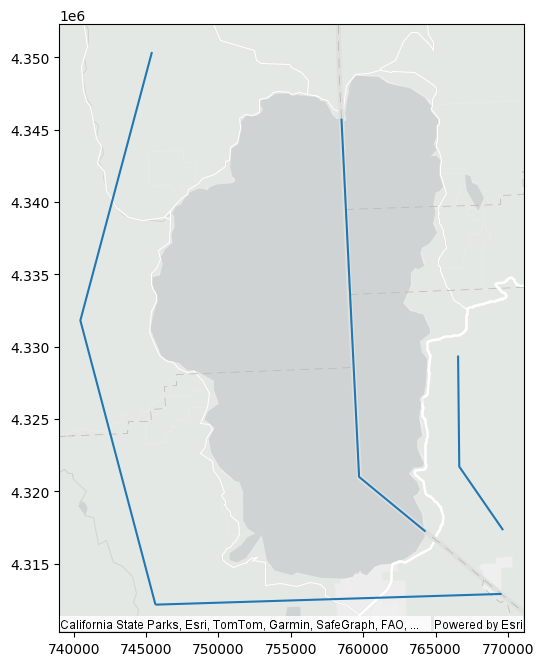

In [6]:
# Needed to make the plots appear in the notebook
%matplotlib inline

# Plot the tracks (lines)
geom_df.st.plot(aspect="equal", figsize=(6,8), basemap="light"); 

### Use SQL functions to calculate the overland search area

The overland search area should meet the following conditions: 
1. Cover the track lines around the lake plus a 1 kilometer buffer
2. The search area should only be on land, it shouldn't cover the lake


Before running the analysis, calculate the distance of the lines in kilometers to understand the coverage using [ST_Length](https://developers.arcgis.com/geoanalytics/sql-functions/st_length/).

In [7]:
# Get the length of the lines. The geometries are returned in the unit of the spatial reference, in this case, meters.
geom_df.select(ST.length("geometry").alias("meters"), (ST.length("geometry")/1000).alias("kilometers")).show(truncate=False)

+------------------+------------------+
|meters            |kilometers        |
+------------------+------------------+
|39505.16921892448 |39.50516921892448 |
|23927.982740016865|23.927982740016866|
|13002.545912878391|13.002545912878391|
|30713.79990187067 |30.71379990187067 |
+------------------+------------------+



The lines range from 13 kilometers to 39.5 kilometers. 

The next step is to calculate a one kilometer buffer of each line. The [ST_Buffer](https://developers.arcgis.com/geoanalytics/sql-functions/st_buffer/) function uses the units of the input spatial reference for the distance value. In this case, buffer by 1 kilometer = 1000 meters. 

+-------+--------------------+--------------------+
|line_id|            geometry|              buffer|
+-------+--------------------+--------------------+
|      0|{"paths":[[[74540...|{"rings":[[[74564...|
|      1|{"paths":[[[74564...|{"rings":[[[74564...|
|      2|{"paths":[[[76966...|{"rings":[[[76966...|
|      3|{"paths":[[[76429...|{"rings":[[[76429...|
+-------+--------------------+--------------------+



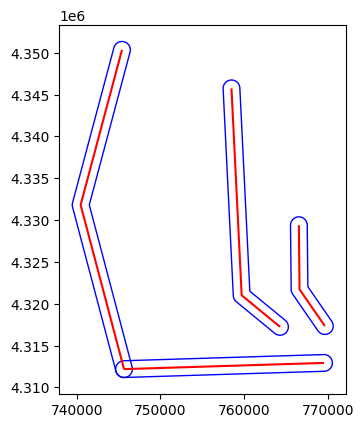

In [8]:
df_buffer = geom_df.withColumn("buffer", ST.buffer(geometry="geometry", distance=1000))
df_buffer.show()

# Plot the buffer polygons and lines
ax = df_buffer.st.plot("geometry", facecolor="none", edgecolor="red")
df_buffer.st.plot("buffer", ax=ax, facecolor="none", edgecolor="blue");

There are a few ways to calculate a polygon to cover the buffered lines of interest. These include:
- Get the minimum and maximum x- and y-coordinates
- Get the envelope of the union of the buffered lines (aligned to x,y)
- Get the minimum bounding rectangle (not aligned to x,y)
- Get the convex hull

All options are shown below, and ultimately the convex hull is used to calculate the overland area. 

#### Get the minimum and maximum x and y values

In [9]:
# Calculate the bounding area using the minimum and maximum x- and y-coordinates
minxy = df_buffer.withColumn("min_x", ST.min_x("buffer")).withColumn("min_y", ST.min_y("buffer")).\
withColumn("max_x", ST.max_x("buffer")).withColumn("max_y", ST.max_y("buffer"))

minxy.select("min_x", "max_x", "min_y","max_y").show(truncate=False)

+-----------+-----------+------------+------------+
|min_x      |max_x      |min_y       |max_y       |
+-----------+-----------+------------+------------+
|739456.0998|746645.1947|4311180.3375|4351363.2255|
|744645.1947|770561.701 |4311180.3375|4313921.3398|
|765554.807 |770663.8653|4316331.4107|4330390.0323|
|757496.6481|765298.3925|4316235.5774|4346755.1707|
+-----------+-----------+------------+------------+



#### Union the geometries and find the envelope

The same values can be found by unioning all of the geometries using [ST_Aggr_Union](https://developers.arcgis.com/geoanalytics/sql-functions/st_aggr_union/) and finding the envelope ([ST_Envelope](https://developers.arcgis.com/geoanalytics/sql-functions/st_envelope/)) that surrounds them.

In [10]:
# Union the geometries and use ST_Envelope to get the same values (minx/miny, maxx/maxy)
df_envelope = df_buffer.select(ST.envelope(ST.aggr_union("buffer")).alias("envelope"))

df_envelope.select(ST.min_x("envelope"), ST.min_y("envelope"), ST.max_x("envelope"), ST.max_y("envelope")).show(truncate=False)

+-----------------+-----------------+-----------------+-----------------+
|ST_MinX(envelope)|ST_MinY(envelope)|ST_MaxX(envelope)|ST_MaxY(envelope)|
+-----------------+-----------------+-----------------+-----------------+
|739456.0998      |4311180.3375     |770663.8653      |4351363.2255     |
+-----------------+-----------------+-----------------+-----------------+



#### Union the geometries and find the minimum bounding box
Use [ST_MinBoundingBox](https://developers.arcgis.com/geoanalytics/sql-functions/st_min_bounding_box/) to calculate a minimum bounding box that isn't aligned to the x,y axis (like `ST_Envelope`)

In [11]:
# Union the geometries and use ST_MinBoundingBox to get the minumum bounding rectangle that isn't aligned to the xy axis. 
df_bound = df_buffer.select(ST.min_bounding_box(geometry=ST.aggr_union("buffer"), by_area=False).alias("envelope"))

df_bound.select(ST.min_x("envelope"), ST.min_y("envelope"), ST.max_x("envelope"), ST.max_y("envelope")).show(truncate=False)

+-----------------+-----------------+-----------------+-----------------+
|ST_MinX(envelope)|ST_MinY(envelope)|ST_MaxX(envelope)|ST_MaxY(envelope)|
+-----------------+-----------------+-----------------+-----------------+
|734976.356663186 |4305743.621520898|772040.8823404367|4355441.166231216|
+-----------------+-----------------+-----------------+-----------------+



#### Union the geometries and calculate the convex hull
Use [ST_ConvexHull](https://developers.arcgis.com/geoanalytics/sql-functions/st_convex_hull/) to create a convex hull polygon from the buffered tracks.

In [12]:
# Create a convex hull polygon out of the line segments
df_convex_hull=df_buffer.select(ST.convex_hull(ST.aggr_union("buffer")).alias("convex_hull"))
df_convex_hull.show(1, truncate = False)
df_convex_hull.st.get_spatial_reference()

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|convex_hull                                                                                                                                                                                                               |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"rings":[[[745645.1947,4311180.3375],[745579.7915707699,4311182.478576762],[745514.66850778,4311188.8926386265],[745450.1043779838,4311199.552219597],[745386.3756548974,4311214.411673712],[745323.... (3948 characters)|
+-------------------------------------------------------------------------------------------------------------------

SpatialReference(srid=26910, is_projected=True, unit='Meter', wkt='PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')

#### Plot all bounding areas to compare

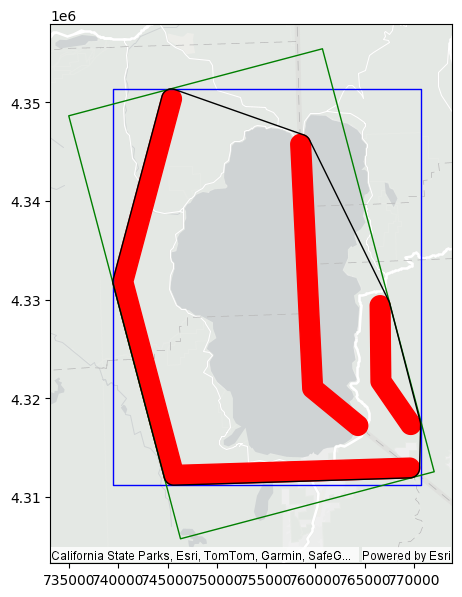

In [13]:
# Plot all options on top of each other to compare outputs
ax = df_buffer.st.plot("buffer", facecolor="red", edgecolor="red", figsize=(7,7))
df_envelope.st.plot(ax=ax, geometry="envelope", aspect="equal", edgecolor = "blue", facecolors="none", figsize=(7,7))
df_bound.st.plot(ax=ax, geometry="envelope", aspect="equal", edgecolor = "green", facecolors="none", figsize=(7,7))
df_convex_hull.st.plot(ax=ax, geometry="convex_hull", aspect="equal", edgecolor = "black", facecolors="none", 
                       figsize=(7,7), basemap="light");

### Read in the Lake Tahoe feature service
[Read a feature service](https://developers.arcgis.com/geoanalytics/tutorials/data/read-from-feature-services/) representing Lake Tahoe into a DataFrame.

+--------------------+
|               shape|
+--------------------+
|{"rings":[[[75878...|
|{"rings":[[[75355...|
+--------------------+
only showing top 2 rows

SpatialReference(srid=26910, is_projected=True, unit='Meter', wkt='PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')


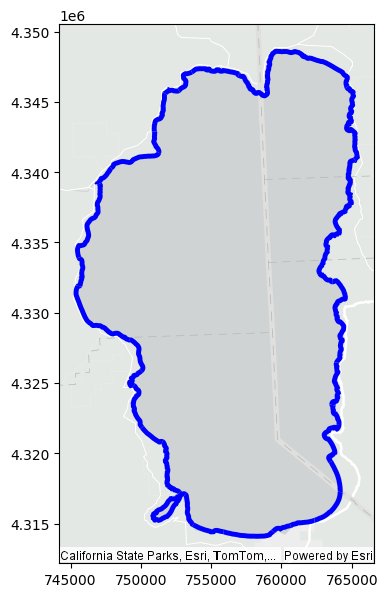

In [14]:
# The feature service used below was created using the dataset found here: 
# https://data-trpa.opendata.arcgis.com/datasets/TRPA::scenic-shoreline-1/about 
lake_tahoe_FS ="https://services1.arcgis.com/36PP9fe9l4BSnArw/ArcGIS/rest/services/Lake_Tahoe_scenic_shoreline/FeatureServer/0"
lake_tahoe = spark.read.format('feature-service').load(lake_tahoe_FS)

lake_tahoe.select("shape").show(2, truncate=True)

print(lake_tahoe.st.get_spatial_reference())
lake_tahoe.st.plot(aspect="equal", facecolor="blue", figsize=(7,7), basemap="light");

#### Calculate the complete lake polygon from the shoreline polygon
The Lake Tahoe dataset is a polygon, but only represents the shoreline. This analysis requires the polygon of the complete lake. The complete polygon will be calculated by:
1. Creating a minimum bounding lake of the current shorelines polygon
2. Finding the union between the bounding area and the shorelines
3. Selecting the unioned polygons that represent the lake

<Axes: >

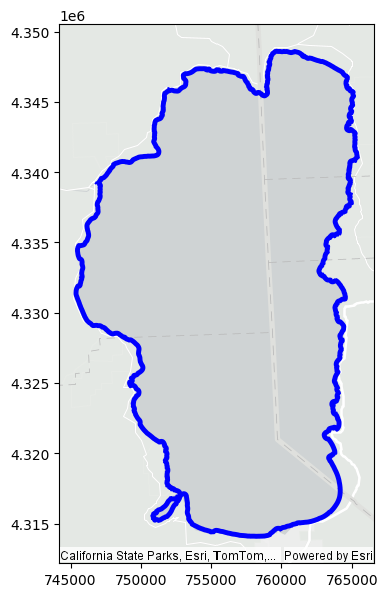

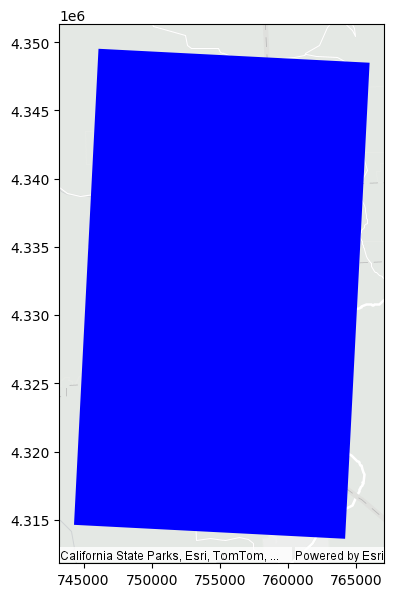

In [15]:
# Get the union of the current shoreline so it's represented as a single polygon
df_lake = lake_tahoe.select(ST.aggr_union("shape").alias("geom_union"))
df_lake.st.plot(aspect="equal", facecolor="blue", figsize=(7,7), basemap="light")

# Find the bounding box of the polygon
lake_bounds = df_lake.select(ST.min_bounding_box("geom_union").alias("geom_bounds"))
lake_bounds.st.plot(aspect="equal", facecolor="blue", figsize=(7,7), basemap="light")

geom_union
geom_bounds
+--------------------+--------------------+--------------------+
|          geom_union|         geom_bounds|    overlay_geometry|
+--------------------+--------------------+--------------------+
|{"rings":[[[75953...|{"rings":[[[76416...|{"rings":[[[74903...|
|                NULL|{"rings":[[[76416...|{"rings":[[[74464...|
+--------------------+--------------------+--------------------+

overlay_geometry


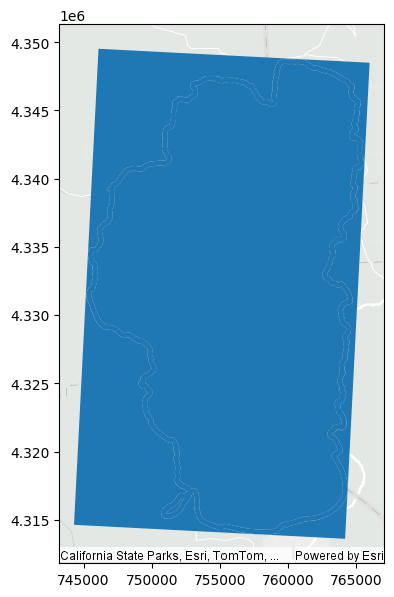

In [16]:
# Calculate the union between the bounding box and the shoreline polygon
from geoanalytics.tools import Overlay

# Before running the tool, check which fields are used for geometry, and verify they are the expected (they are)
print(df_lake.st.get_geometry_field())
print(lake_bounds.st.get_geometry_field())

# Run the union tool
overlay_result=Overlay() \
            .setOverlayType(overlay_type="Union") \
            .run(input_dataframe=df_lake, overlay_dataframe=lake_bounds)
overlay_result.show(5)

# Plot the unioned geometries
print(overlay_result.st.get_geometry_field())
overlay_result.st.plot(aspect="equal", figsize=(7,7), basemap="light");

Next, extract the unioned polygons that will be used for further analysis:
1. The original shoreline data
2. The polygons representing the lakes

The original shoreline data is stored in the `df_lake` DataFrame, so there isn't any additional work needed. The polygons representing the lake are stored in the `overlay_results` DataFrame where the union is `NULL`. Below, determine how many polygons are in the `overlay_result` DataFrame, and which ones represent the lake using plotting, then use the [ST_Area](https://developers.arcgis.com/geoanalytics/sql-functions/st_area/) calculation.

+--------------------+---------+
|        n_geometries|num_parts|
+--------------------+---------+
|[{"rings":[[[7446...|        7|
+--------------------+---------+



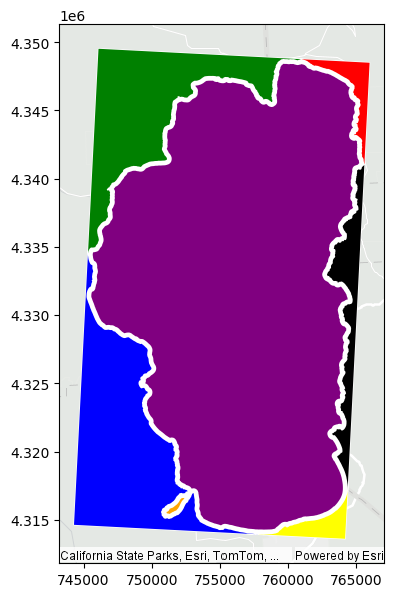

In [17]:
# Visualize the different polygons in the overlay result
x = overlay_result.filter("geom_union IS NULL")
num = x.select(ST.geometries("overlay_geometry").alias("n_geometries")).select("n_geometries", F.size("n_geometries")\
                                                                       .alias("num_parts"))
num.show()
col = ["blue", "green", "red","purple", "yellow", "black", "orange"]

ax = overlay_result.st.plot(aspect="equal", color="white", figsize=(7,7), basemap="light")
for i in range(0, 7):
    y = x.select(ST.geometry_n("overlay_geometry", i).alias("geometry_n"))
    y.st.plot("geometry_n", ax=ax, facecolor=col[i])

In [18]:
# Find the largest polygon by area, which represents the large lake area and the smallest polygon by area, which represents the small lake area in the south west. 
largest_area = 0
smallest_area = 500000
i = 0
for i in range(0, 7):
    y = x.select(ST.geometry_n("overlay_geometry",i).alias("geometry_n"))
    area = y.select(ST.area("geometry_n").alias("area"))
    value = area.select("area").collect()[0][0]
    if value > largest_area:
        largest_area = value
        largest_i = i
    elif value < smallest_area:
        smallest_area = value
        smallest_i = i

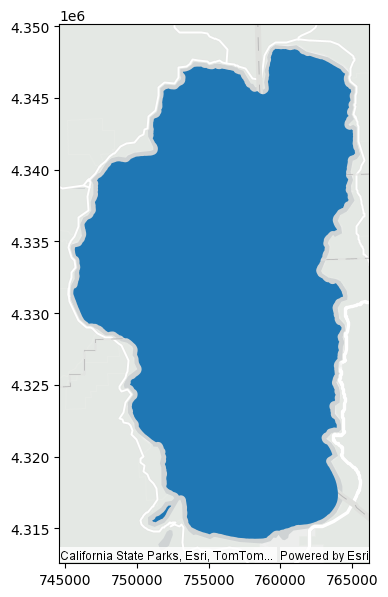

In [19]:
# Plots the selected results to verify you've selected the correct polygons
y = x.select(ST.union(ST.geometry_n("overlay_geometry", largest_i), ST.geometry_n("overlay_geometry", smallest_i)))
y.st.plot(aspect="equal", figsize=(7,7), basemap="light");

root
 |-- geom_union: polygon (nullable = true)
 |-- ST_Union(ST_GeometryN(overlay_geometry, 3), ST_GeometryN(overlay_geometry, 6)): polygon (nullable = true)
 |-- overlay_geometry: polygon (nullable = true)

+--------------------+
|      geometry_tahoe|
+--------------------+
|{"rings":[[[74961...|
+--------------------+



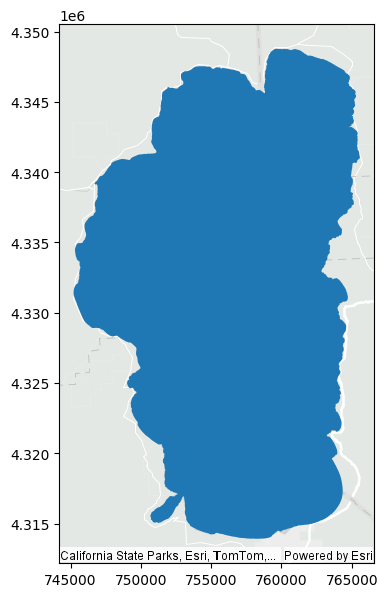

In [20]:
# Join the lake and the lake shoreline together to make sure it's the complete lake and shoreline
overlay_result=Overlay() \
            .setOverlayType(overlay_type="Union") \
            .run(input_dataframe=df_lake, overlay_dataframe=y)

# Check the schema of the result to ensure you use the correct geometry field in the next step
overlay_result.printSchema()

# Create the Tahoe lake DataFrame using aggregate union
df_tahoe = overlay_result.select(ST.aggr_union("overlay_geometry").alias("geometry_tahoe"))
df_tahoe.show()
df_tahoe.st.plot(aspect="equal", figsize=(7,7), basemap="light");

Now that the complete Lake Tahoe polygon is created `df_tahoe`, join the Lake Tahoe polygon and the convex hull in order to use them with [ST_Difference](https://developers.arcgis.com/geoanalytics/sql-functions/st_difference/) to calculate the overland area. The Overland search area is the convex hull of the tracks with the lake removed.

root
 |-- convex_hull: geometry (nullable = true)
 |-- lake_tahoe: polygon (nullable = true)



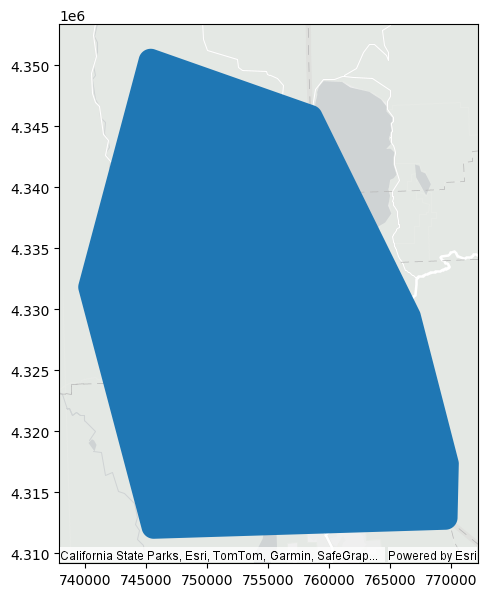

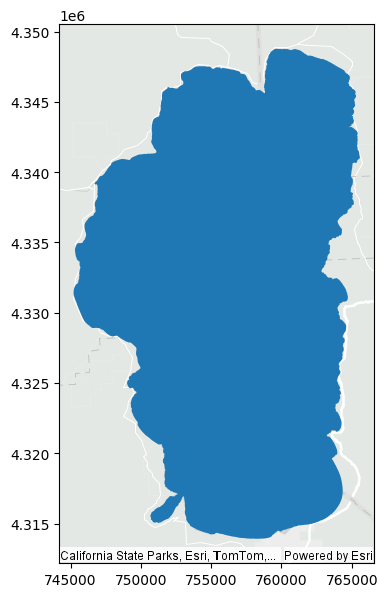

In [21]:
# Join the polygons to each other so it's a single DataFrame
geom_pairs = df_convex_hull.join(df_tahoe.select(F.col("geometry_tahoe").alias("lake_tahoe")))
geom_pairs.printSchema()
geom_pairs.select(ST.geometry_type("convex_hull"), ST.geometry_type("lake_tahoe"))

# Plot both geometries that you'll be using
geom_pairs.st.plot(geometry="convex_hull", aspect="equal", figsize=(7,7), basemap="light")
geom_pairs.st.plot(geometry="lake_tahoe", aspect="equal", figsize=(7,7), basemap="light");

+--------------------+
|          difference|
+--------------------+
|{"rings":[[[74564...|
+--------------------+



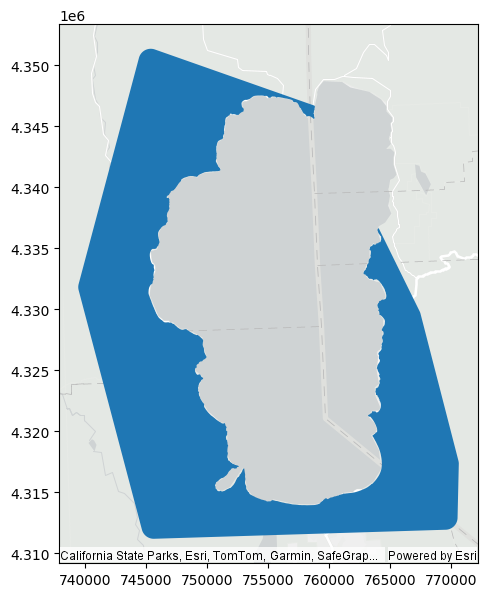

In [22]:
# Calculate the difference between the two polygons
difference = geom_pairs.select(ST.difference(ST.aggr_union("convex_hull"), ST.aggr_union("lake_tahoe")).alias("difference"))
difference.show()
difference.st.plot(geometry="difference", aspect="equal", figsize=(7,7), basemap="light");

You now have a polygon representing the overland search area.